In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
import re
import seaborn as sns
import random
from sklearn import svm
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.utils.np_utils import to_categorical


In [3]:
# test data and test data directory 

data_dir = "/content/drive/MyDrive/ELEC378_FinalProject/data/data"

test_dir = "/content/drive/MyDrive/ELEC378_FinalProject/test/test"



Containis function for feature extraction. Takes a directory and a boolean indicating wheather to split the data or not. For cross validation use the data directory (labeled data) and split = true. Run all the way to the cell that prints out accuracy score. For testing model on the unlabled data in test folder (those that are named sample001, etc), run the cells below the accuracy score cell will give you a .csv file ready for submission on kaggle. 

In [16]:
#@title Feature Extraction func
def FeatureExtraction (dir, split=True): 
 
  '''
  Function for feature extraction. Change this section to change what features we are using. 

  input: a directory of the data. Will split to test and train, a boolean: if split is true, will extract features and labels and store them in 4 arrays:
  train_data, train_label, test_data, test_label. if split is false, function will extract all data provided in the directory and output 2 arrays with values 2 arrays that are empty. 
  Use labeled data and split = false will give you  (train_data, train_label); use unlabled data and split = false will give you (test_data, test_label).

  output: data matrix and lables for both test and train. 

  '''
  audio_files = [f for f in os.listdir(dir) if f.endswith(".wav")]
  
  train_files, test_files = train_test_split(audio_files, test_size=0.2)

  train_data = []
  train_label= []
  test_data  = []
  test_label = []  
  
  
  for file_name in audio_files:

      # Load audio
      file_path = os.path.join(dir, file_name)
      raw_audio, sr = librosa.load(file_path)

      # if audio is too short, append zeros after it. 
      if np.shape(raw_audio)[0] < 80000: 
          padded_audio = np.pad(raw_audio, [(0, 80000 - np.shape(raw_audio)[0])], mode='constant')
      else:
          padded_audio = raw_audio

      # now slice so that we guarantee that each array has the same length
      audio = padded_audio[20000:80000]

      # feature extraction

      mfccs = librosa.feature.mfcc(y=audio, sr = 22050, n_mfcc = 20)
      delta_mfccs = librosa.feature.delta(mfccs)
      spec_centroid = librosa.feature.spectral_centroid(y = audio)

    

      # Concatenate
      features = np.concatenate([mfccs, delta_mfccs, spec_centroid ], axis = 0)
      #features = mfccs

      label_map = {'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}
      label = file_name.split(".")[0]

      #unlabeled data
      if label[:-3] == "sample":
        test_data.append(features)
        test_label.append(label)

      #labeled data
      else:
        if split: 
          if file_name in train_files:
            train_data.append(features)
            label = re.sub('[^a-z]', "", label)
            train_label.append(label_map[label])

          elif file_name in test_files: 
            test_data.append(features)
            label = re.sub('[^a-z]', "", label)
            test_label.append(label_map[label])

        elif not split: 
          
          train_data.append(features)
          label = re.sub('[^a-z]', "", label)
          train_label.append(label_map[label])
  

  train_data = np.array(train_data)
  train_label = np.array(train_label)
  test_data = np.array(test_data)
  test_label = np.array(test_label) 

  print("feature size is:", np.shape(features))
  print("spec centroid:", np.shape(spec_centroid))
  return train_data, train_label, test_data, test_label



In [17]:
X_train, y_train, X_test, y_test = FeatureExtraction(data_dir, split = True)
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)


feature size is: (41, 118)
spec centroid: (1, 118)


In [ ]:
#@title SVM
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(kernel = "linear"))
clf.fit(X_train, y_train)

y_predicted= clf.predict(X_test)

accuracy = accuracy_score(y_test, y_predicted)

print(accuracy)


In [12]:
import keras
from keras.layers import Conv1D, Embedding, Dropout, MaxPooling1D, GlobalMaxPooling1D, Dense
from keras.optimizers import Adam
from keras import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [24]:
num_classes = 8
def build_cnn(input_shape, num_classes):
    model = tf.keras.Sequential()
    
    # Convolutional layers
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='valid', input_shape=input_shape))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    

    model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='valid'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


    model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='valid'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.1))
    
    # Dense layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(2048))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(num_classes))
    model.add(tf.keras.layers.Activation('softmax'))
    
    
    return model

Epoch 1/200
28/29 [===========================>..] - ETA: 0s - loss: 2.4195 - accuracy: 0.3560
Epoch 1: val_accuracy improved from -inf to 0.18222, saving model to best_model.h5
29/29 [==============================] - 6s 74ms/step - loss: 2.4137 - accuracy: 0.3578 - val_loss: 10.1251 - val_accuracy: 0.1822
Epoch 2/200
28/29 [===========================>..] - ETA: 0s - loss: 1.3485 - accuracy: 0.5703
Epoch 2: val_accuracy did not improve from 0.18222
29/29 [==============================] - 1s 31ms/step - loss: 1.3444 - accuracy: 0.5711 - val_loss: 4.5861 - val_accuracy: 0.1733
Epoch 3/200
27/29 [==========================>...] - ETA: 0s - loss: 0.9747 - accuracy: 0.6736
Epoch 3: val_accuracy improved from 0.18222 to 0.27111, saving model to best_model.h5
29/29 [==============================] - 3s 111ms/step - loss: 0.9733 - accuracy: 0.6711 - val_loss: 2.9592 - val_accuracy: 0.2711
Epoch 4/200
28/29 [===========================>..] - ETA: 0s - loss: 0.6959 - accuracy: 0.7589
Epoch 4:

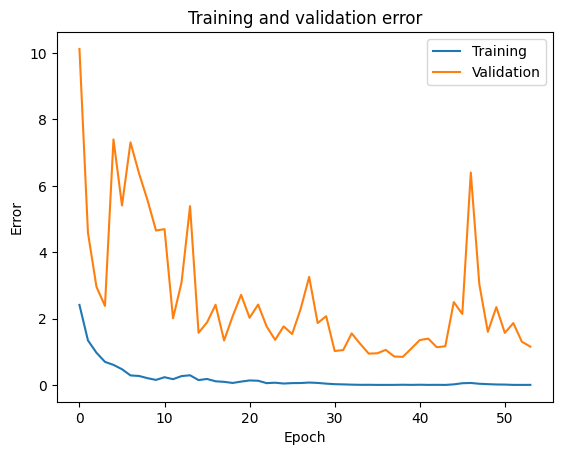

In [25]:
#num frames is number of wav files
es = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=15, verbose=1)

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

#num frames is number of wav files
model = build_cnn((X_train.shape[1], X_train.shape[2], 1), num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train_ohe, batch_size=32, epochs=200, validation_data=(X_test, y_test_ohe), callbacks=[es, checkpoint])


# plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [54]:
import tensorflow as tf

# Define the input shape
input_shape = (79, 118, 1)

# Define the model architecture
input_layer = tf.keras.Input(shape=input_shape)
conv1 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
bn1 = tf.keras.layers.BatchNormalization()(conv1)
bn1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(bn1)

conv2 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(bn1)
bn2 = tf.keras.layers.BatchNormalization()(conv2)

# First branch to detect rougher features
branch1 = tf.keras.layers.Conv2D(128, kernel_size=(5, 5), activation='relu', padding='same')(bn2)

branch1 = tf.keras.layers.BatchNormalization()(branch1)


# Second branch to detect finer features
branch2 = tf.keras.layers.Conv2D(128, kernel_size=(2, 2), activation='relu', padding='same')(bn2)
branch2 = tf.keras.layers.BatchNormalization()(branch2)


# Merge the two branches
merged = tf.keras.layers.concatenate([branch1, branch2])

flatten = tf.keras.layers.Flatten()(merged)
dense = tf.keras.layers.Dense(512, activation='relu')(flatten)
output_layer = tf.keras.layers.Dense(8, activation='softmax')(dense)


model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
history = model.fit(X_train, y_train_ohe, batch_size=32, epochs=40, validation_data=(X_test, y_test_ohe))


# plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()



Epoch 1/40


ValueError: ignored

In [29]:
#actually only need to extract filename here. But I can't be arsed to write another func.

dummy1, dummy2, X_test, y_test = FeatureExtraction(test_dir, split = False)


feature size is: (41, 118)
spec centroid: (1, 118)


In [30]:
model.load_weights('best_model.h5')
y_predicted = model.predict(X_test)

10/10 [==============================] - 0s 28ms/step


In [32]:

y_predicted_ohv = np.argmax(y_predicted, axis = 1)

print(y_predicted_ohv)
label_map = {'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}

def dict_search(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key

y_predicted_label = []
for i in y_predicted_ohv: 
    val = dict_search(label_map, i)
    y_predicted_label.append(val)


print(y_predicted_label)

[1 2 6 1 2 4 5 0 6 2 3 2 2 2 1 1 5 2 3 2 7 1 2 6 0 5 1 1 7 0 5 5 6 1 0 0 2
 3 4 0 3 2 1 2 2 1 2 2 2 5 1 2 0 0 3 6 0 5 2 3 7 3 3 3 4 6 2 0 6 0 3 2 6 4
 5 4 3 2 3 6 5 0 2 7 3 4 6 2 0 6 3 0 2 3 1 7 2 5 1 3 6 6 2 2 1 3 6 1 3 4 6
 1 3 6 4 7 3 6 3 0 2 2 7 7 7 3 6 3 7 1 4 2 7 4 0 7 4 2 4 2 2 1 2 0 6 7 4 5
 7 4 5 5 7 0 3 6 3 3 4 6 1 4 1 7 1 1 1 7 2 6 3 6 2 0 4 0 7 7 1 1 2 0 7 1 2
 5 6 7 0 0 7 1 0 6 0 3 3 0 3 2 7 5 0 0 2 1 5 6 7 1 6 1 7 1 4 5 0 1 0 4 3 1
 4 3 6 1 1 2 6 1 1 3 0 6 6 2 0 1 2 5 3 4 4 1 6 1 3 7 0 4 5 2 4 2 4 0 6 4 3
 6 6 3 4 1 7 2 0 6 0 7 0 3 5 3 6 6 7 7 1 4 4 1 3 4 1 2 0 4 4 4 6 1 5 3 0 4
 1 2 1 2 1 7 1 2 0 2 5 2 7 0 1 4 0 1 2]
['calm', 'disgust', 'sad', 'calm', 'disgust', 'happy', 'neutral', 'angry', 'sad', 'disgust', 'fearful', 'disgust', 'disgust', 'disgust', 'calm', 'calm', 'neutral', 'disgust', 'fearful', 'disgust', 'surprised', 'calm', 'disgust', 'sad', 'angry', 'neutral', 'calm', 'calm', 'surprised', 'angry', 'neutral', 'neutral', 'sad', 'calm', 'angry', 'angry', 'disgust', 

In [33]:
import csv

def make_csv(unlabeled_file_name, y_predicted_label):
  with open('prediction.csv', mode='w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['filename', 'label'])
      for i in range(len(unlabeled_file_name)):
        writer.writerow([unlabeled_file_name[i], y_predicted_label[i]])
  file.close()

make_csv(y_test, y_predicted_label)